# Deep Learning Project - Traffic Sign Recognition using Convolutional Neural Networks

**Group 2 members:** <br>
Bruno Belo, R20170735 <br>
Rui Monteiro, R20170796 <br>
Tomás Santos, R20170734 <br>

**MSc:** Data Science and Advanced Analytics - Nova IMS <br>
**Course:** Deep Learning <br>
2020/2021

## Introduction
???

## Setup Environment
To run this Notebook without issues, the user can fork and clone our **GitHub repository** available at https://github.com/rfmmonteiro99/DL-Project-Final.

Furthermore, the user needs an Anaconda environment with all the used libraries. A yml file is provided on our GitHub repository (link above) for that purpose. The user can **create the environment** with the ???.yml file, by following these steps:
1. Put the yml file on a folder or even on the Desktop
2. Open Anaconda Navigator
3. Go to "Environments"
4. Click on "Import"
5. Name the new environment on "Name", and find the path to your file on "Specification File" (you may need to specify you want to search for txt files on the "Import Environment" box)
6. Click on "Import" so that Anaconda starts loading all the packages
7. Finally, navigate to the new environment on "Home" and launch Jupyter Notebook

In [27]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2
#import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

## 1. Importing and Exploring Data

In [2]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((30,30)) # Resizing the images to 30x30
            image = np.array(image)
            data.append(image)
            labels.append(i)
            
        except:
            print('Error loading an image')

In [3]:
# Converting lists into Numpy arrays
data = np.array(data)
labels = np.array(labels)

In [4]:
# Check data shape (3 colour channels: Red, Green, Blue)
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [5]:
# Number of classes for this classification problem
unique_signs = np.unique(labels)

len(unique_signs)

43

In [6]:
# Dictionary with the labels of all traffic signs
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

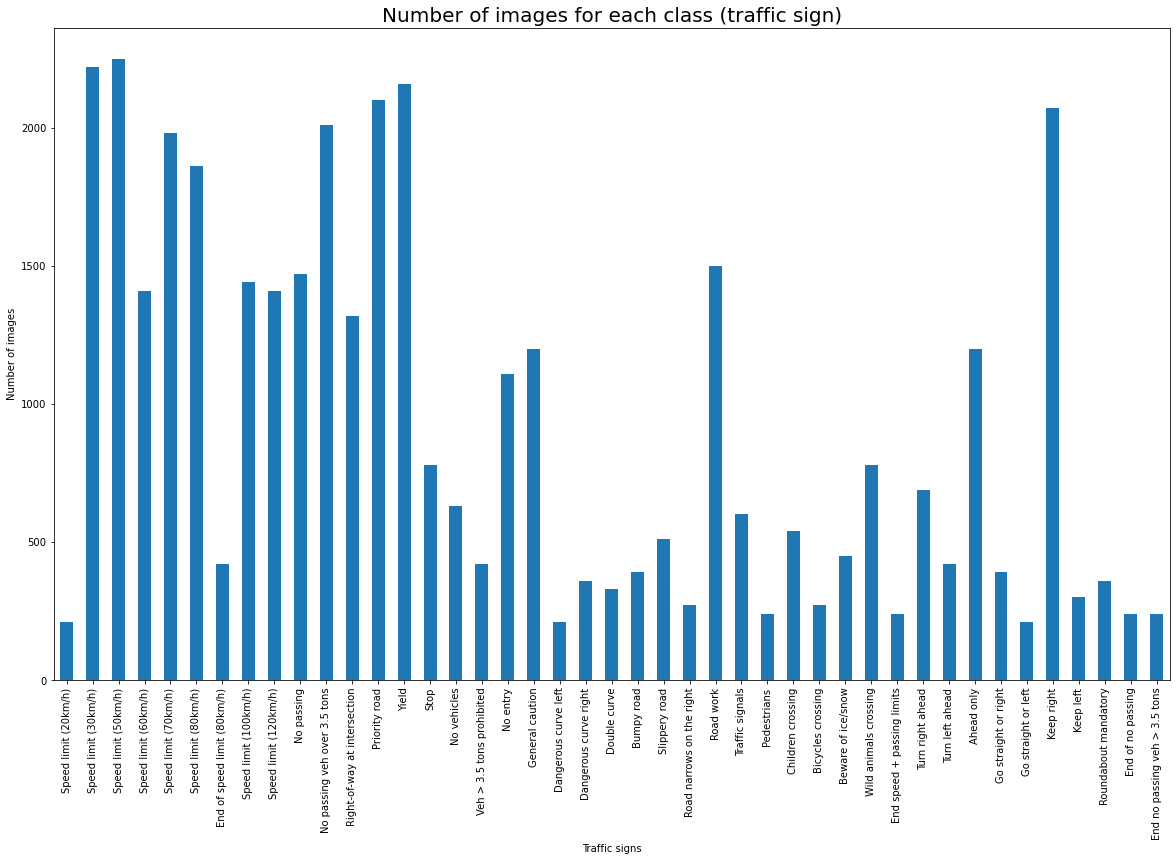

In [7]:
# Getting a list with the classes' names
signs_names = []

for i in range(len(classes)):
    signs_names.append(classes[i])

#graph = pd.DataFrame(np.array([pd.Series(labels).value_counts().sort_index(), signs_names])).T

# Barplot
pd.Series(labels).value_counts().sort_index().plot.bar(figsize=(20, 12)).set_xticklabels(signs_names)

# Labelling the plot and both axes
plt.title('Number of images for each class (traffic sign)', size=20)
plt.xlabel('Traffic signs')
plt.ylabel('Number of images')

plt.show()

In [8]:
def show_20_images(images, labels):
    """
    Displays a plot with 20 random images and their respective classes.
    """
    plt.figure(figsize=(16, 16))
    for i in range(20):
        ax = plt.subplot(5, 5, i+1)
        
        rand = random.randint(1, len(data)-20)
        
        plt.imshow(images[i+rand])
        plt.title(signs_names[labels[i+rand]])
        
        plt.suptitle('Traffic signs examples', size=20)
        plt.axis("off")

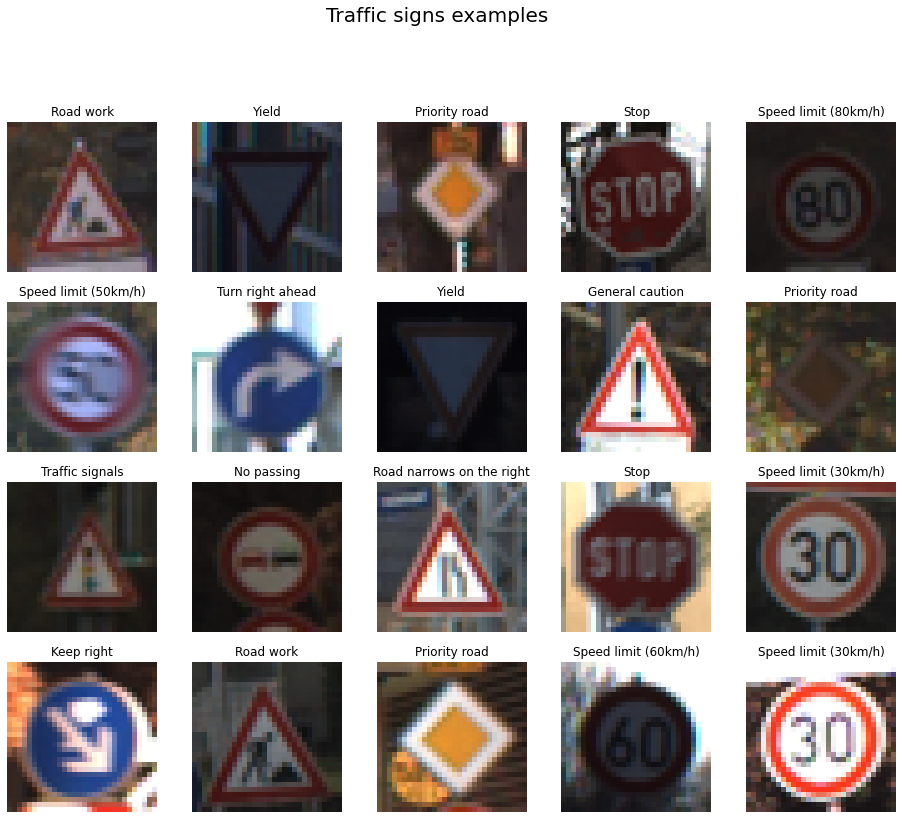

In [17]:
show_20_images(data, labels)

## 2. Data Preprocessing

In [9]:
# All the pixel values on the array are between 0 and 255, so to rescale them to a [0, 1] interval, we can just divide 
# the values by 255
data_normalized = data / 255

## 3. Train-Validation Split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(data_normalized, 
                                                  labels, 
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  shuffle=True)

In [11]:
print("X_train shape", X_train.shape)
print("X_val shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_val.shape", y_val.shape)

X_train shape (27446, 30, 30, 3)
X_val shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_val.shape (11763,)


## 4. One-Hot Encoding the Labels

In [12]:
# Converting the labels with one-hot encoding
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

## 5. CNN Models

In [70]:
# Simple CNN
def cnn_1(input_shape):
    classifier = Sequential()
    
    classifier.add(Conv2D(32, (5, 5), input_shape = input_shape, activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    
    classifier.add(Conv2D(64, (5, 5), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    
    classifier.add(Flatten())

    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(Dense(units = 43, activation = 'softmax'))
    
    return classifier

In [14]:
# Similar to cnn_1, but with Dropout
def cnn_2(input_shape):
    classifier = Sequential()
    
    classifier.add(Conv2D(32, (5, 5), input_shape = input_shape, activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(64, (5, 5), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Flatten())

    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(Dropout(rate=0.5))
    classifier.add(Dense(units = 43, activation = 'softmax'))
    
    return classifier

In [28]:
# cnn_2, but with BatchNormalization
# https://keras.io/api/layers/normalization_layers/batch_normalization/
# https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
# Once implemented, batch normalization has the effect of dramatically accelerating the training process of a neural 
# network, and in some cases improves the performance of the model via a modest regularization effect.
def cnn_3(input_shape):
    classifier = Sequential()
    
    classifier.add(Conv2D(32, (5, 5), input_shape = input_shape, activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(64, (5, 5), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPool2D(pool_size = (2, 2)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.25))
    
    classifier.add(Flatten())

    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(rate=0.5))
    classifier.add(Dense(units = 43, activation = 'softmax'))
    
    return classifier

In [ ]:
# cnn_3 mas com RMSprop para comparar

In [ ]:
# fazer uma nova com regularizers
# https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

### 5.1. Data Augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# The rotations and flips can potentially harm the quality of the model (some signs look like others if they are rotated),
# so we will avoid using those parameters
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

### 5.2. Callbacks

In [29]:
import keras

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5),
    keras.callbacks.ModelCheckpoint(
        filepath = 'cnn_model_file',
        monitor='val_loss',
        save_best_only=True)
]

### 5.3. Compile and Fit

**a) cnn_1:**

In [78]:
# Get the model
cnn_1_model = cnn_1((30,30,3))

# Compile
from keras import optimizers

opt = optimizers.RMSprop(lr = 1e-4) # Try Adam

cnn_1_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Try 64 batches
epochs = 30

history_1 = cnn_1_model.fit(aug.flow(X_train, y_train, batch_size=32),
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
857/858 [============================>.] - ETA: 0s - loss: 3.2589 - accuracy: 0.1307WARNING:tensorflow:From C:\Users\ruifi\anaconda3\envs\DLclasses\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cnn_1_model_file\assets
858/858 [==============================] - 56s 66ms/step - loss: 3.2584 - accuracy: 0.1308 - val_loss: 2.8801 - val_accuracy: 0.2307
Epoch 2/30
858/858 [==============================] - 59s 68ms/step - loss: 2.7444 - accuracy: 0.2437 - val_loss: 2.3665 - val_accuracy: 0.3077
Epoch 3/30
858/858 [==============================] - 57s 67ms/step - loss: 2.

In [80]:
# Model summary
cnn_1_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 26, 26, 32)        2432      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)             

**b) cnn_2:**

In [17]:
# Get the model
cnn_2_model = cnn_2((30,30,3))

# Compile
from keras import optimizers

opt = optimizers.RMSprop(lr = 1e-4) # Try Adam

cnn_2_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Try 64 batches
epochs = 30

history_2 = cnn_2_model.fit(aug.flow(X_train, y_train, batch_size=32),
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - ETA: 0s - loss: 3.4770 - accuracy: 0.0761WARNING:tensorflow:From C:\Users\ruifi\anaconda3\envs\DLclasses\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cnn_1_model_file\assets
858/858 [==============================] - 64s 75ms/step - loss: 3.4770 - accuracy: 0.0761 - val_loss: 3.2413 - val_accuracy: 0.1530
Epoch 2/30
858/858 [==============================] - 60s 69ms/step - loss: 3.1162 - accuracy: 0.1479 - val_loss: 2.8273 - val_accuracy: 0.2096
Epoch 3/30
858/858 [==============================] - 60s 70ms/step - loss: 2.

Epoch 27/30
858/858 [==============================] - 62s 72ms/step - loss: 0.5145 - accuracy: 0.8363 - val_loss: 0.1515 - val_accuracy: 0.9678
Epoch 28/30
858/858 [==============================] - 61s 71ms/step - loss: 0.5051 - accuracy: 0.8416 - val_loss: 0.1328 - val_accuracy: 0.9679
Epoch 29/30
858/858 [==============================] - 64s 75ms/step - loss: 0.4792 - accuracy: 0.8473 - val_loss: 0.1325 - val_accuracy: 0.9711
Epoch 30/30
858/858 [==============================] - 59s 69ms/step - loss: 0.4563 - accuracy: 0.8533 - val_loss: 0.1154 - val_accuracy: 0.9731


In [18]:
# Model summary
cnn_2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         7

**c) cnn_3:**

In [30]:
# Get the model
cnn_3_model = cnn_3((30,30,3))

# Compile
from keras import optimizers

opt = optimizers.Adam() # https://keras.io/api/optimizers/adam/

cnn_3_model.compile(loss='categorical_crossentropy', 
                    optimizer=opt, 
                    metrics=['accuracy'])

# Try 64 batches
epochs = 30

history_3 = cnn_3_model.fit(aug.flow(X_train, y_train, batch_size=32),
                            epochs=epochs, 
                            callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 71s 82ms/step - loss: 2.7471 - accuracy: 0.2974 - val_loss: 1.0745 - val_accuracy: 0.6495
Epoch 2/30
858/858 [==============================] - 69s 81ms/step - loss: 1.2737 - accuracy: 0.6033 - val_loss: 0.3389 - val_accuracy: 0.8888
Epoch 3/30
858/858 [==============================] - 72s 84ms/step - loss: 0.8648 - accuracy: 0.7283 - val_loss: 0.1953 - val_accuracy: 0.9392
Epoch 4/30
858/858 [==============================] - 70s 81ms/step - loss: 0.6844 - accuracy: 0.7854 - val_loss: 0.1762 - val_accuracy: 0.9424
Epoch 5/30
858/858 [==============================] - 62s 73ms/step - loss: 0.5940 - accuracy: 0.8139 - val_loss: 0.1773 - val_accuracy: 0.9465
Epoch 6/30
858/858 [==============================] - 70s 81ms/step - loss: 0.5257 - accuracy: 0.8358 - val_loss: 0.0665 - val_accuracy: 0.9812
Epoch 7/30
858/858 [==============================] - 63s 74ms/step - loss: 0.4815 - accuracy: 0.8488 - val_loss: 0.1078 - val_accuracy:

In [31]:
# Model summary
cnn_3_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 64)         

## 6. Evaluating the Model

**a) cnn_1:**

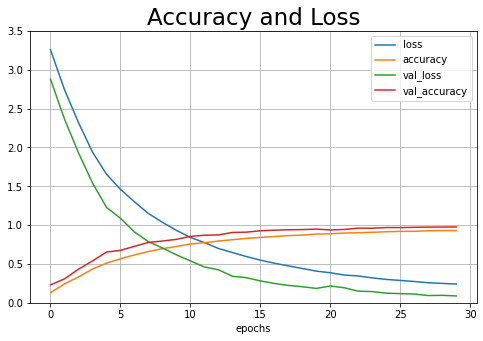

In [84]:
pd.DataFrame(history_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3.5)

plt.title('Accuracy and Loss', size=23)
plt.xlabel('epochs')

plt.show()

**b) cnn_2:**

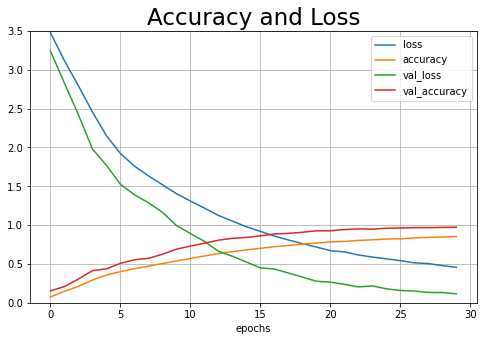

In [19]:
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3.5)

plt.title('Accuracy and Loss', size=23)
plt.xlabel('epochs')

plt.show()

**c) cnn_3:**

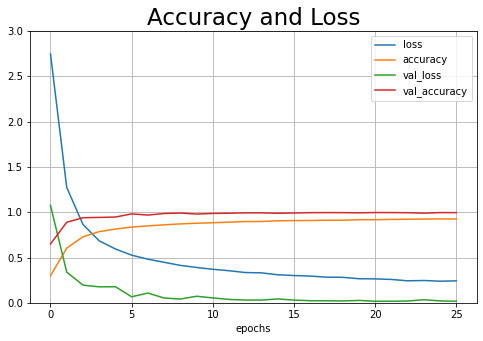

In [33]:
pd.DataFrame(history_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)

plt.title('Accuracy and Loss', size=23)
plt.xlabel('epochs')

plt.show()

## 7. Importing the Test dataset

In [20]:
y_test = pd.read_csv('Test.csv')
labels_test = y_test["ClassId"].values
imgs = y_test["Path"].values
data_test = []

for img in imgs:
    image = Image.open(img)
    image = image.resize((30,30))
    data_test.append(np.array(image))
    
X_test = np.array(data_test)

In [21]:
# Check data shape (3 colour channels: Red, Green, Blue)
print(X_test.shape, labels_test.shape)

(12630, 30, 30, 3) (12630,)


In [22]:
# Normalization
X_test = X_test / 255

## 8. Making Predictions and Evaluating the measures

In [23]:
from sklearn.metrics import accuracy_score, classification_report

**a) cnn_1:**

In [94]:
# Prediction with the first CNN (cnn_1_model)
pred_1 = cnn_1_model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [95]:
print('Test Dataset accuracy:', round(accuracy_score(labels_test, pred_1)*100, 2))

Test Dataset accuracy: 91.03


In [96]:
print(classification_report(labels_test, pred_1))

              precision    recall  f1-score   support

           0       0.88      0.63      0.74        60
           1       0.88      0.99      0.93       720
           2       0.84      0.96      0.89       750
           3       0.93      0.88      0.90       450
           4       0.98      0.89      0.93       660
           5       0.84      0.81      0.83       630
           6       0.97      0.96      0.97       150
           7       0.93      0.90      0.92       450
           8       0.94      0.93      0.94       450
           9       0.97      0.89      0.93       480
          10       0.94      0.98      0.96       660
          11       0.90      0.93      0.91       420
          12       1.00      0.90      0.94       690
          13       0.99      0.99      0.99       720
          14       0.90      0.99      0.94       270
          15       1.00      0.99      0.99       210
          16       0.91      1.00      0.95       150
          17       0.99    

**b) cnn_2:**

In [24]:
# Prediction with the second CNN (cnn_2_model)
pred_2 = cnn_2_model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [25]:
print('Test Dataset accuracy:', round(accuracy_score(labels_test, pred_2)*100, 2))

Test Dataset accuracy: 93.8


In [26]:
print(classification_report(labels_test, pred_2))

              precision    recall  f1-score   support

           0       1.00      0.62      0.76        60
           1       0.87      1.00      0.93       720
           2       0.98      0.95      0.96       750
           3       0.98      0.92      0.95       450
           4       0.99      0.95      0.97       660
           5       0.94      0.92      0.93       630
           6       0.92      0.99      0.96       150
           7       0.93      0.94      0.94       450
           8       0.94      0.96      0.95       450
           9       1.00      1.00      1.00       480
          10       0.99      1.00      0.99       660
          11       0.93      0.93      0.93       420
          12       1.00      0.93      0.97       690
          13       0.97      1.00      0.98       720
          14       1.00      1.00      1.00       270
          15       0.94      0.99      0.96       210
          16       0.94      1.00      0.97       150
          17       1.00    

**c) cnn_3:**

In [35]:
# Prediction with the third CNN (cnn_3_model)
pred_3 = cnn_3_model.predict_classes(X_test)

In [36]:
print('Test Dataset accuracy:', round(accuracy_score(labels_test, pred_3)*100, 2))

Test Dataset accuracy: 96.58


In [37]:
print(classification_report(labels_test, pred_3))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        60
           1       0.92      1.00      0.96       720
           2       0.96      0.94      0.95       750
           3       0.99      0.94      0.96       450
           4       1.00      0.97      0.98       660
           5       0.96      0.93      0.95       630
           6       0.97      0.99      0.98       150
           7       1.00      0.95      0.97       450
           8       0.92      1.00      0.96       450
           9       0.98      1.00      0.99       480
          10       1.00      0.99      0.99       660
          11       0.99      0.97      0.98       420
          12       1.00      0.88      0.94       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.95      1.00      0.97       210
          16       0.99      1.00      1.00       150
          17       1.00    

In [ ]:
# Save the best model
???.save('traffic_signs_classifier.h5')

## Code References

A: <br>


B: <br>


C: <br>


D: <br>

